In [1]:
import urllib2
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc

1) Load in the dataset `https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv` into a pandas dataframe

In [2]:
dataset = urllib2.urlopen('https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv')
data = pd.read_csv(dataset)

In [3]:
data.head()


,Unnamed: 0,default,student,balance,income
0,1,No,No,729.526495,44361.625074
1,2,No,Yes,817.180407,12106.134700
2,3,No,No,1073.549164,31767.138947
3,4,No,No,529.250605,35704.493935
4,5,No,No,785.655883,38463.495879


In [4]:
data.shape

(10000, 5)

2) Convert `default` and `student` to categorical variables.

In [5]:
df_default = pd.get_dummies(data['default'])
df_student = pd.get_dummies(data['student'])
data_final = pd.concat([data[['balance','income']],df_default,df_student],axis=1)
data_final.columns = ['balance','income','default-No','default-Yes','Student-No','Student-Yes']
data_final.head()

,balance,income,default-No,default-Yes,Student-No,Student-Yes
0,729.526495,44361.625074,1.0,0.0,1.0,0.0
1,817.180407,12106.134700,1.0,0.0,0.0,1.0
2,1073.549164,31767.138947,1.0,0.0,1.0,0.0
3,529.250605,35704.493935,1.0,0.0,1.0,0.0
4,785.655883,38463.495879,1.0,0.0,1.0,0.0


3) Make boxplots of all of the variables and a scatter plot of of (balance,income) with the color
of the outcome of `default` labeled red if yes and blue if no. 

/Users/lingxiangyu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.
  if __name__ == '__main__':


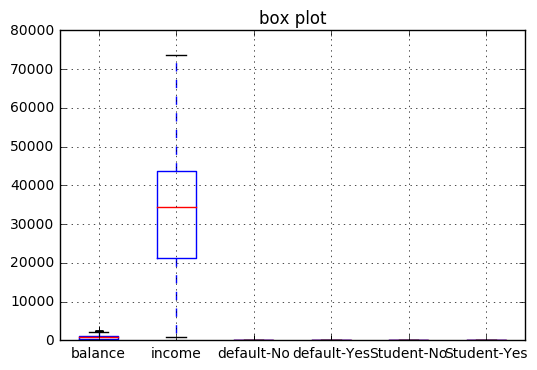

In [33]:
data_final.boxplot()
plt.title('box plot')
plt.show()

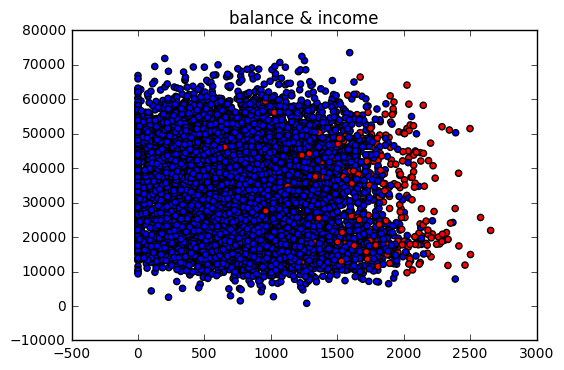

In [45]:
fig, ax = plt.subplots()
col = {0:'red', 1:'blue'}
ax.scatter(data_final.balance, data_final.income, c=data_final['default-No'].apply(lambda x: col[x]))
plt.title('balance & income')
plt.show()

4) Train a model to predict if a student defaults on their loan or not using LogisticRegression based soley
on the `balance` and `income` variables. Plot the decision boundary in the scatter plot you made in 3) and compute the AUC ROC.

In [61]:
X1 = data_final[['balance','income']]
y1 = data_final[['default-No']]

scaler = StandardScaler()
X1 = scaler.fit_transform(X1)

n1_samples, n1_features = X1.shape

half = int(n1_samples/2)
X1_train, X1_test = X1[:half], X1[half:]
y1_train, y1_test = y1[:half], y1[half:]




In [56]:
regr1 = LogisticRegression()
model1 = regr1.fit(X1_train, y1_train)
probs = model1.predict_proba(X1_test)
coeff1 = regr1.coef_
inter1 = regr1.intercept_
#plt.contour(X1_test,y1_test, probs1, levels=[0.5])
#plt.show()

In [68]:
coeff1[0,0]

-2.566073383548463

In [76]:
coeff1[0,1]

-0.34412226932007284

In [70]:
inter1[0]

5.7113737017899382

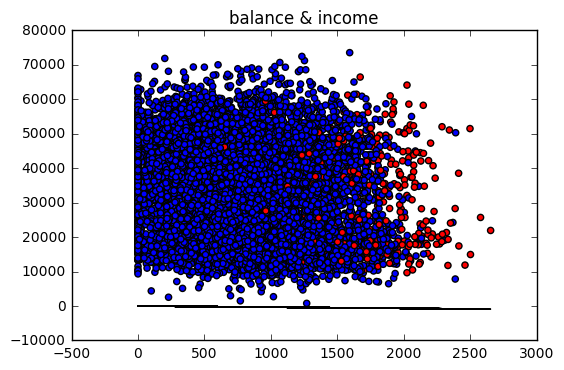

In [75]:
fig, ax = plt.subplots()
col = {0:'red', 1:'blue'}
ax.scatter(data_final.balance, data_final.income, c=data_final['default-No'].apply(lambda x: col[x]))
plt.title('balance & income')

plt.plot(data_final.balance, data_final.balance*coeff1[0,1] + inter1[0], 'black')

plt.show()

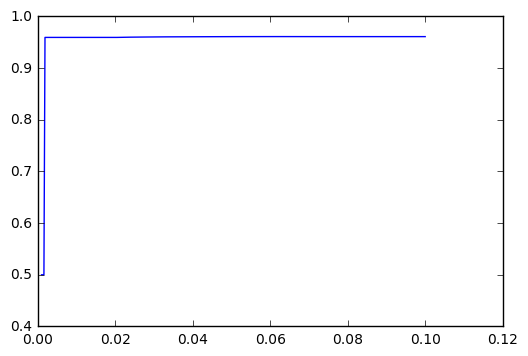

[0.5,
 0.5,
 0.5,
 0.5,
 0.95941688624126464,
 0.95941688624126464,
 0.95941688624126464,
 0.95941688624126464,
 0.95941688624126464,
 0.95941688624126464,
 0.95941688624126464,
 0.95941688624126464,
 0.95941688624126464,
 0.95941688624126464,
 0.95941688624126464,
 0.95941688624126464,
 0.95941688624126464,
 0.95941688624126464,
 0.95941688624126464,
 0.95941688624126464,
 0.95988944896322603,
 0.96019017069538315,
 0.96049089242754038,
 0.96063409325237703,
 0.96080593424218141,
 0.96096345514950166,
 0.96102073547943634,
 0.96096345514950154,
 0.96094913506701785,
 0.96094913506701796]

In [11]:
#compute AUC ROC
def generate_auc(X,y,clf_class,**kwargs):
    random_state = np.random.RandomState(0)
    X, y = shuffle(X, y, random_state=random_state)
    n_samples, n_features = X.shape
    half = int(n_samples/1.2)
    X_train, X_test = X[:half], X[half:]
    y_train, y_test = y[:half], y[half:]
    
    classifier = clf_class(**kwargs)
    probas_ = classifier.fit(X_train, y_train).predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, roc_auc, thresholds


alphas = np.logspace(-3,-1,30)
scores = []

for alpha in alphas:
    regr = LogisticRegression(C=alpha,penalty='l1')

    fpr, tpr, roc_auc, thresholds= generate_auc(X1,y1,LogisticRegression,C=alpha,penalty='l1')
    scores.append(roc_auc)

plt.plot(alphas,scores)
plt.show()
scores

5) Repeat 4) but with the student variable included. Optimize using Ridge regression and plot the ranking
of coefficients.  How does performance improve with the added variable?

6) Using cross validation, check that the model you built in 5) is robust (generalizes to other random folds of the dataset).

7) Train a Decision Tree classifier with maximum depth 5 and plot the decision tree. How does performance compare?

8) Find the optimal decision tree depth and compute the AUC ROC. 